# [FORECASTING](http://telegra.ph/forecasting-10-24)


demand forecasting is based on SHCHUKA 2014-2017

### importing

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 # будем отображать графики прямо в jupyter'e
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


Populating the interactive namespace from numpy and matplotlib


### common


In [2]:
def printError(str):
    print("\x1b[31m", str, "\x1b[0m")    
def printSuccess(str):
    print('\033[92m' + str +"\x1b[0m")
def printInfo(str):
    print('\033[94m' + str +"\x1b[0m")

### prepare source data

In [3]:
def removeHeaderRows(data_raw):
    data_raw.drop(data_raw.index[[0,1,2,3,4]], inplace=True)
        
def removeSingleValueColumn(col_name, data):
    if (len(data[col_name].unique()) == 1):
        print('remove column: ', col_name)
        return data.drop(col_name, 1)
    
#read raw data
from pandas import read_csv
data_raw2014 = read_csv("~/Documents/imagineML/data/current/data2014.csv") #щука
data_raw2015 = read_csv("~/Documents/imagineML/data/current/data2015.csv")
data_raw2016 = read_csv("~/Documents/imagineML/data/current/data2016.csv")
data_raw2017 = read_csv("~/Documents/imagineML/data/current/data2017.csv")
totalrows = data_raw2014.shape[0] + data_raw2015.shape[0] + data_raw2016.shape[0] + data_raw2017.shape[0]
print("~rows: ",totalrows)

removeHeaderRows(data_raw2014)
removeHeaderRows(data_raw2015)
removeHeaderRows(data_raw2016)
removeHeaderRows(data_raw2017)

df = pd.concat([data_raw2014, data_raw2015, data_raw2016, data_raw2017], axis=0)
df = df.reset_index(drop=True)
print("actual rows: ", df.shape[0])

df.columns = ['date', 'col1', 'warehouse', 'col2', 'name', 'col3', 'id', 'qtyBefore', 'qty']
df = removeSingleValueColumn('col1', df)
df = removeSingleValueColumn('col2', df)
df = removeSingleValueColumn('col3', df)
df = removeSingleValueColumn('warehouse', df)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['date'] = df['date'].dt.date
df['qtyBefore'] = df['qtyBefore'].astype('float')
df['qty'] = df['qty'].astype('float')
df.head()

~rows:  96579
actual rows:  96559
remove column:  col1
remove column:  col2
remove column:  col3
remove column:  warehouse


,date,name,id,qtyBefore,qty
0,2014-07-11,Батарейки мизинчиковые ААА LR03 12 в уп. бата...,УТ000001012,144.0,3.0
1,2014-07-11,Блокнотик Светская львица,СК-00001146,1.0,1.0
2,2014-07-11,Визитница Для покупочек,01-00002742,2.0,1.0
3,2014-07-11,Визитница Мои скидочки,01-00000889,2.0,1.0
4,2014-07-11,Визитница Особы приближенные к императору,УТ000000026,2.0,1.0


In [4]:
#release memory
del [data_raw2014,data_raw2015, data_raw2016, data_raw2017]

### select sales data

In [5]:
# id, name, date, sale
sales = df[['id', 'name', 'date', 'qty']]
sales.rename(columns={'qty': 'sales'}, inplace=True)
sales.head()

,id,name,date,sales
0,УТ000001012,Батарейки мизинчиковые ААА LR03 12 в уп. бата...,2014-07-11,3.0
1,СК-00001146,Блокнотик Светская львица,2014-07-11,1.0
2,01-00002742,Визитница Для покупочек,2014-07-11,1.0
3,01-00000889,Визитница Мои скидочки,2014-07-11,1.0
4,УТ000000026,Визитница Особы приближенные к императору,2014-07-11,1.0


### select balance data

In [6]:
# id, name, date, balance
balance = df[['id', 'name', 'date', 'qtyBefore']]
balance.rename(columns={'qtyBefore': 'balance'}, inplace=True)
balance.head()

,id,name,date,balance
0,УТ000001012,Батарейки мизинчиковые ААА LR03 12 в уп. бата...,2014-07-11,144.0
1,СК-00001146,Блокнотик Светская львица,2014-07-11,1.0
2,01-00002742,Визитница Для покупочек,2014-07-11,2.0
3,01-00000889,Визитница Мои скидочки,2014-07-11,2.0
4,УТ000000026,Визитница Особы приближенные к императору,2014-07-11,2.0


### filter data

In [7]:
# filter based on validation: remove items where sales < 0
items_sales_min = sales.groupby(['id'])['sales'].min()
items_sales_min = items_sales_min.to_frame().reset_index()
items_sales_min = items_sales_min.sort_values(by=['sales'])
items_sales_min.head(10) #7 items

incorrect = len(items_sales_min[items_sales_min['sales'] < 1])
if (incorrect > 0):
    printError("found " + str(incorrect) + " items with sales < 1")

 found 7 items with sales < 1 


In [8]:
# filter unsold items: remove items where qty == 0 during all period (2014-2017)
items_sales_total = sales.groupby(['id'])['sales'].sum()
items_sales_total = items_sales_total.to_frame().reset_index()
items_sales_total = items_sales_total.sort_values(by=['sales'])
items_sales_total.head() # 1 item

,id,sales
4303,99-00004449,0.5
1745,06-00000047,1.0
607,01-00001046,1.0
3889,99-00003473,1.0
1699,01-00003462,1.0


In [9]:
#release memory
#del [items_sales_min, items_sales_total]
del items_sales_min

### unique items ids

In [10]:
item_unique_ids = sales['id'].unique()

### group by  month, 2 weeks,  week

In [11]:
temp = sales[['date', 'id', 'name', 'sales']]
temp['month_str'] = temp['date'].map(lambda x: x.month).astype(str)
temp['year_str'] = temp['date'].map(lambda x: x.year).astype(str)
temp['day'] = temp['date'].map(lambda x: x.day)

def getGrouppedSales(temp_df):
    temp_df = temp_df.groupby(['id', 'key_date'])['sales'].sum()
    temp_df = temp_df.to_frame().reset_index()
    groupped_sales = temp_df.pivot(index='key_date', columns='id', values='sales')   
    groupped_sales.reset_index(level=0, inplace=True)
    del temp_df
    return groupped_sales


In [12]:
#month
#key date is the 1st day of month
temp_month = temp[['id', 'name', 'sales', 'date', 'month_str', 'year_str']]
temp_month['key'] = temp_month['year_str'] + "-" + temp_month['month_str'] + "-1"
temp_month['key_date'] = pd.to_datetime(temp_month['key'], format='%Y-%m-%d') 
sales_month = getGrouppedSales(temp_month)
del temp_month
sales_month.head()

id,key_date,00-00000003,00-00000004,00-00000005,00-00000009,00-00000010,00-00000011,00-00000012,00-00000018,00-00000021,...,УТ000000984,УТ000000998,УТ000001012,УТ000001013,УТ000001139,УТ000001140,УТ000001251,УТ000001301,УТ000001302,ЯЧ-00000001
0,2014-07-01,4.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,19.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-08-01,1.0,3.0,8.0,1.0,2.0,NaN,NaN,NaN,NaN,...,6.0,NaN,107.0,104.0,NaN,3.0,2.0,3.0,NaN,NaN
2,2014-09-01,7.0,10.0,9.0,NaN,NaN,1.0,NaN,1.0,NaN,...,5.0,NaN,129.0,80.0,NaN,6.0,NaN,3.0,NaN,NaN
3,2014-10-01,2.0,5.0,9.0,NaN,NaN,1.0,NaN,1.0,NaN,...,6.0,NaN,126.0,127.0,NaN,4.0,NaN,4.0,NaN,NaN
4,2014-11-01,2.0,8.0,8.0,2.0,NaN,1.0,NaN,2.0,1.0,...,2.0,NaN,81.0,98.0,NaN,1.0,NaN,2.0,NaN,NaN


In [13]:
#2 weeks 
#key date =  set 1st day - if 1st or 2nd week of month, and 15th day - if 3rd or 4th week of month
temp_2week = temp[['id', 'name', 'sales', 'date', 'month_str', 'year_str', 'day']]
temp_2week['week_str'] = np.where(temp_2week['day'] < 15, '1', '15')
temp_2week['key'] = temp_2week['year_str'] + "-" + temp_2week['month_str'] + '-' + temp_2week['week_str']
temp_2week['key_date'] = pd.to_datetime(temp_2week['key'], format='%Y-%m-%d')
sales_2week = getGrouppedSales(temp_2week)
del temp_2week
sales_2week.head()

id,key_date,00-00000003,00-00000004,00-00000005,00-00000009,00-00000010,00-00000011,00-00000012,00-00000018,00-00000021,...,УТ000000984,УТ000000998,УТ000001012,УТ000001013,УТ000001139,УТ000001140,УТ000001251,УТ000001301,УТ000001302,ЯЧ-00000001
0,2014-07-01,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-07-15,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,12.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-08-01,NaN,2.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,...,2.0,NaN,35.0,46.0,NaN,NaN,NaN,1.0,NaN,NaN
3,2014-08-15,1.0,1.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,...,4.0,NaN,72.0,58.0,NaN,3.0,2.0,2.0,NaN,NaN
4,2014-09-01,4.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,68.0,38.0,NaN,6.0,NaN,NaN,NaN,NaN


In [14]:
#weekly
#key date =  day of month defined by function below
def define_week(x):
    if (x > 0 and x < 8):
        return '1'
    if (x > 7 and x < 15):
        return '8'
    if (x > 14 and x < 22):
        return '15'
    if (x > 21 and x < 32):
        return '22'

temp_week = temp[['id', 'name', 'sales', 'date', 'month_str', 'year_str', 'day']]
temp_week['week_str'] = temp_week['day'].map(lambda x: define_week(x))
temp_week['key'] = temp_week['year_str'] + "-" + temp_week['month_str'] + '-' + temp_week['week_str']
temp_week['key_date'] = pd.to_datetime(temp_week['key'], format='%Y-%m-%d')
sales_week = getGrouppedSales(temp_week)
del temp_week

sales_week.head()

id,key_date,00-00000003,00-00000004,00-00000005,00-00000009,00-00000010,00-00000011,00-00000012,00-00000018,00-00000021,...,УТ000000984,УТ000000998,УТ000001012,УТ000001013,УТ000001139,УТ000001140,УТ000001251,УТ000001301,УТ000001302,ЯЧ-00000001
0,2014-07-08,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-07-15,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,6.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-07-22,3.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-08-01,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,19.0,33.0,NaN,NaN,NaN,1.0,NaN,NaN
4,2014-08-08,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,16.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#daily
# key date is the same as date
temp_day = temp[['id', 'name', 'sales', 'date']]
temp_day['key_date'] = temp_day['date']
sales_day = getGrouppedSales(temp_day)
del temp_day

sales_day.head()

id,key_date,00-00000003,00-00000004,00-00000005,00-00000009,00-00000010,00-00000011,00-00000012,00-00000018,00-00000021,...,УТ000000984,УТ000000998,УТ000001012,УТ000001013,УТ000001139,УТ000001140,УТ000001251,УТ000001301,УТ000001302,ЯЧ-00000001
0,2014-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-07-12,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-07-14,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-07-15,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN


### validate time series consistency

In [16]:
# time interval between any two neighbour points of time series should be the same
# each point should be presented only one time 
import datetime 

one_month = '1 month'
two_weeks = '2 weeks'
one_week = '1 week'
one_day = '1 day'


def missingDates(cur, target):
    temp = pd.DataFrame({'actual': cur, 'target': target})
    
def weekFirstDate(date):
    week_first_date = date
    if (week_first_date.day > 1):
        week_first_date = week_first_date.replace(day=1)
    return week_first_date
    
def getExpectedDateTimeSeries(dates, time_interval):
    start_date = dates.min()
    end_date = dates.max()   
    if (time_interval == one_month):
        expected_dates = pd.date_range(start_date, end_date, freq="MS")
    elif (time_interval == two_weeks):
        first_weeks = pd.date_range(weekFirstDate(start_date), end_date, freq="MS") #first week
        second_weeks = first_weeks.map(lambda x: x + datetime.timedelta(days=14)) #second week
        expected_dates = first_weeks.append(second_weeks).sort_values()
        expected_dates = expected_dates[np.logical_and(expected_dates >= start_date, expected_dates <= end_date)]
    elif (time_interval == one_week):
        first_weeks = pd.date_range(weekFirstDate(start_date), end_date, freq="MS") #first week
        second_weeks = first_weeks.map(lambda x: x + datetime.timedelta(days=7)) #second week
        third_weeks = first_weeks.map(lambda x: x + datetime.timedelta(days=14)) #third week
        fourth_weeks = first_weeks.map(lambda x: x + datetime.timedelta(days=21)) #third week
        expected_dates = first_weeks.append(second_weeks).append(third_weeks).append(fourth_weeks).sort_values()
        expected_dates = expected_dates[np.logical_and(expected_dates >= start_date, expected_dates <= end_date)]
    elif (time_interval == one_day):
        expected_dates = pd.date_range(start_date, end_date, freq="1d")
    return expected_dates
    

def validTimeSeriesInternal(dates, time_interval):
    if (len(dates) != len(dates.unique())):
        print("Dates vector is not unque!")
        return (False, [])
    
    expected_dates = getExpectedDateTimeSeries(dates, time_interval)
    if (len(expected_dates) == len(dates)):
        date_df = pd.DataFrame({'date': dates, 'expected_date': expected_dates})
        date_df['isValid'] = date_df['date'] == date_df['expected_date']
        isValid = (False in date_df['isValid'].unique()) == False            
    else:
        print("Time series is not valid!","actual:", len(dates), "expected:", len(expected_dates))
        isValid = False            
    return (isValid, expected_dates)

def validTimeSeries(data, time_interval):
    dates = data['key_date']
    result_ts = validTimeSeriesInternal(dates, time_interval)
    if(result_ts[0]):
        print("", time_interval, "time series VALID")
    else:
        printError(time_interval + " time series NOT valid")
        if (len(dates) < len(result_ts[1])):
            printError("Series has missing dates")
            if (time_interval == one_day):
                data = data.sort_values(by=['key_date'], ascending=[True])
                data.set_index('key_date', inplace=True)
                data.index = pd.to_datetime(data.index,  format='%Y-%m-%d')
                data = data.resample('D').reset_index()   
                printSuccess(" missing values fixed")
        else:
            printError("Series has extra dates. Error in grouping or validation") 
    return data
            
        
def showMissingValues(data, expected):
    dates = data['key_date']
    curr_dates_df = pd.DataFrame({'cur_date': dates})
    curr_dates_df['cur_date'] = pd.to_datetime(curr_dates_df['cur_date'])
    expected_dates_df = pd.DataFrame({'expected_date': expected})
    diff_dates = curr_dates_df.merge(expected_dates_df, how='outer', left_on='cur_date', right_on="expected_date")
    missing_dates = diff_dates[diff_dates['cur_date'].isnull()]['expected_date']
    print(missing_dates)
    #print(diff_dates[diff_dates['cur_date'].isnull()]['expected_date'])
   

In [17]:
sales_month = validTimeSeries(sales_month, one_month)
sales_2week = validTimeSeries(sales_2week, two_weeks)
sales_week = validTimeSeries(sales_week, one_week)
sales_day =  validTimeSeries(sales_day, one_day)

 1 month time series VALID
 2 weeks time series VALID
 1 week time series VALID
Time series is not valid! actual: 1134 expected: 1137
 1 day time series NOT valid 
 Series has missing dates 
 missing values fixed


In [313]:
print(len(sales_month), len(sales_2week), len(sales_week), len(sales_day))

38 76 150 1137


### checking result

In [18]:
unique_count = len(item_unique_ids)
sales_summary = pd.DataFrame({'item': item_unique_ids, 
                              one_month:  np.repeat(np.nan, unique_count), 
                              two_weeks:  np.repeat(np.nan, unique_count), 
                              one_week:  np.repeat(np.nan, unique_count), 
                              one_day:  np.repeat(np.nan, unique_count),
                              'na':   np.repeat(np.nan, unique_count)})
#sales_summary.set_indexx('item')

def sumSales(x):
    return (sales_month[x].sum(), sales_2week[x].sum(),sales_week[x].sum(), sales_day[x].sum(),
            items_sales_total[items_sales_total['id'] == x].iloc[0]['sales'])

sales_summary[[one_month, two_weeks, one_week, one_day, 'na']] = sales_summary['item'].map(lambda x: sumSales(x)).apply(pd.Series)
sales_summary['isvalid'] = sales_summary[one_month] == sales_summary[one_week]
sales_summary['isvalid'] = np.logical_and(sales_summary['isvalid'], sales_summary[one_month] == sales_summary[one_week])
sales_summary['isvalid'] = np.logical_and(sales_summary['isvalid'], sales_summary[one_month] == sales_summary[one_day])
sales_summary['isvalid'] = np.logical_and(sales_summary['isvalid'], sales_summary[one_month] == sales_summary['na'])
#sales_summary[one_month] == sales_summary[one_day]).values
falsed = sales_summary[~sales_summary['isvalid']]

if (len(falsed) > 0):
    printError("Grouping is not correct: " + str(len(falsed)) + " cases.")
    print(falsed.head(len(falsed)))


 Grouping is not correct: 2 cases. 
      1 day  1 month  1 week  2 weeks         item     na  isvalid
3021  25.01    25.01   25.01    25.01  99-00001166  25.01    False
3572   5.20     5.20    5.20     5.20  99-00002384   5.20    False


In [19]:
item = 'УТ000001012'
itemActual = sales[sales['id'] == item][['date', 'sales']]
itemActual['key'] = itemActual['date'].astype(str)
itemActual = itemActual.groupby(['key'])['sales'].sum()
itemActual = itemActual.to_frame().reset_index()
itemActual['salesA'] = itemActual['sales'].astype(int)
itemCalculated = sales_day[['key_date', item]]
itemCalculated['key'] = itemCalculated['key_date'].astype(str)
itemCalculated['salesC'] = itemCalculated[item]
print('actual', len(itemActual))
print('calc', len(itemCalculated))

compareFull = itemActual.merge(itemCalculated, how='outer', on='key')
compare = compareFull[['key', 'salesA', 'salesC']]
compare = compare.replace(np.nan, 0)
compare['isValid'] = compare['salesA'] == compare['salesC']
compare[~compare['isValid']]
print(compare['salesA'].sum(), compare['salesC'].sum())



check1 = sales[sales['id'] == item][['date', 'sales']]
check1['month'] = check1['date'].map(lambda x: x.month)
check1['year'] = check1['date'].map(lambda x: x.year)
check1['day'] = check1['date'].map(lambda x: x.day) 


actual 495
calc 1137
2511.0 2511.0


In [20]:
se_dates = pd.DataFrame(index=['na', one_month, two_weeks, one_week, one_day], columns = ['start_date', 'end_date'])
se_dates['start_date'] = np.repeat(np.nan, 5)
se_dates['end_date'] = np.repeat(np.nan, 5)

se_dates.set_value(index='na', col='start_date', value=sales['date'].min())
se_dates.set_value(index='na', col='end_date', value=sales['date'].max())

se_dates.set_value(index=one_month, col='start_date', value=sales_month['key_date'].min())
se_dates.set_value(index=one_month, col='end_date', value=sales_month['key_date'].max())

se_dates.set_value(index=two_weeks, col='start_date', value=sales_2week['key_date'].min())
se_dates.set_value(index=two_weeks, col='end_date', value=sales_2week['key_date'].max())

se_dates.set_value(index=one_week, col='start_date', value=sales_week['key_date'].min())
se_dates.set_value(index=one_week, col='end_date', value=sales_week['key_date'].max())

se_dates.set_value(index=one_day, col='start_date', value=sales_day['key_date'].min())
se_dates.set_value(index=one_day, col='end_date', value=sales_day['key_date'].max())

,start_date,end_date
na,2014-07-11,2017-08-20
1 month,2014-07-01 00:00:00,2017-08-01 00:00:00
2 weeks,2014-07-01 00:00:00,2017-08-15 00:00:00
1 week,2014-07-08 00:00:00,2017-08-15 00:00:00
1 day,2014-07-11 00:00:00,2017-08-20 00:00:00


### demand classification

In [21]:
#http://www.pm.lth.se/fileadmin/pm/Exjobb/Exjobb_2017/Sercan_och_Joan/Master_Thesis_Sercan_Eminoglu_Joan_Esteve_7.6.2017.pdf
#page 18

SMOOTH = 'smooth'
ERRATIC = 'erratic'
LUMPY = 'lumpy'
SLOW = 'slow'

def classifyDemand(p, cv2):
#     p = row['p']
#     cv2 = row['CV2']
    if (p >= 1.32):
        if(cv2 >= 0.49):
            return LUMPY
        else: 
            return SLOW
    else:
        if(cv2 >= 0.49):
            return ERRATIC
        else:
            return SMOOTH

def date_range_of_sales(data, x):
    items_sales = data[['key_date', x]]
    items_sales_with_demand = items_sales.loc[items_sales[x] > 0]
    start_date_of_sales = items_sales_with_demand['key_date'].min()
    end_date_of_sales = items_sales_with_demand['key_date'].max()
    return (start_date_of_sales, end_date_of_sales)

def demand_classification(sales_data):
    demand_columns = ['item', 'total_periods', 'periods_with_demand', 'STD', 'Mean', 'STD2', 'Mean2']          
    sold_items = sales_data.columns.values
    sold_items = np.delete(sold_items, np.argwhere(sold_items == 'key_date'))
    demand_index=range(0, len(sold_items))
    demand_classification = pd.DataFrame(index=demand_index, columns=demand_columns)
    demand_classification['item'] = sold_items
    demand_classification['total_periods'] = len(sales_data.index)
    sales_data = sales_data.replace(np.nan, 0)
    demand_classification['periods_with_demand'] =demand_classification['item'].map(lambda x: sales_data[x].astype(bool).sum())
    demand_classification['min'] =demand_classification['item'].map(lambda x: sales_data[x].min())
    demand_classification['max'] =demand_classification['item'].map(lambda x: sales_data[x].max())
    demand_classification[['start_date', 'end_date']] = demand_classification['item'].map(lambda x: date_range_of_sales(sales_data, x)).apply(pd.Series)
    demand_classification['STD'] =demand_classification['item'].map(lambda x: sales_data[x].std())
    demand_classification['Mean'] =demand_classification['item'].map(lambda x: sales_data[x].mean())
    demand_classification['STD2'] =np.power(demand_classification['STD'],2)
    demand_classification['Mean2'] =np.power(demand_classification['Mean'],2)
    demand_classification['T'] = demand_classification['total_periods']
    demand_classification['N-1'] = demand_classification['periods_with_demand'] - 1
    demand_classification['p'] =  demand_classification['T']/demand_classification['N-1']
    demand_classification['CV2'] = demand_classification['STD2']/ demand_classification['Mean2']
    demand_classification['demand'] =  demand_classification.apply(lambda x: classifyDemand(x['p'], x['CV2']), axis=1) 
    date_index = sales_data['key_date'].to_frame()
    demand_classification['start_date_index'] = demand_classification['start_date'].map(lambda x: (date_index.index[date_index['key_date'] == x])[0])
    demand_classification['end_date_index'] = demand_classification['end_date'].map(lambda x: (date_index.index[date_index['key_date'] == x])[0])
    demand_classification['date_index_range'] = demand_classification['end_date_index'] - demand_classification['start_date_index'] + 1
    return demand_classification

demand_month = demand_classification(sales_month)
demand_2week = demand_classification(sales_2week)
demand_week = demand_classification(sales_week)
demand_day = demand_classification(sales_day)

In [22]:
def dTypeCount(demanddata, demandtype):
    return demanddata[demanddata['demand'] == demandtype]['item'].count()

def demandSummary(dm, d2w, dw, dd):
    demandX = [SLOW, SLOW, SLOW, SLOW, LUMPY,LUMPY,LUMPY,LUMPY, ERRATIC,ERRATIC,ERRATIC,ERRATIC, SMOOTH,SMOOTH,SMOOTH,SMOOTH]
    timeIntervalX =  [one_month, two_weeks, one_week, one_day,one_month, two_weeks, one_week, one_day,one_month, two_weeks, one_week, one_day,one_month, two_weeks, one_week, one_day]

    demand_summary = pd.DataFrame({'period' : timeIntervalX, 
                                   'demand' : demandX, 
                                   'data': [dTypeCount(dm, SLOW),dTypeCount(d2w, SLOW),dTypeCount(dw, SLOW),dTypeCount(dd, SLOW), 
                                            dTypeCount(dm, LUMPY),dTypeCount(d2w, LUMPY),dTypeCount(dw, LUMPY),dTypeCount(dd, LUMPY),
                                             dTypeCount(dm, ERRATIC),dTypeCount(d2w, ERRATIC),dTypeCount(dw, ERRATIC),dTypeCount(dd, ERRATIC), 
                                            dTypeCount(dm, SMOOTH),dTypeCount(d2w, SMOOTH),dTypeCount(dw, SMOOTH),dTypeCount(dd, SMOOTH)]})
    
    return demand_summary

demandSummary(demand_month, demand_2week, demand_week, demand_day).pivot(index='period', columns='demand', values='data')

demand,erratic,lumpy,slow,smooth
period,,,,
1 day,0,4976,0,0
1 month,84,4883,0,9
1 week,12,4964,0,0
2 weeks,34,4942,0,0


### double check intermittent demand
check situation
1) end of sales: smooth + 0s
2) start of salse: 0s + smooth


In [23]:
intermittent_demand = [LUMPY, SLOW]
non_intermittent_demand = [ERRATIC, SMOOTH]

def reduceSmoothFromIntermittent(demand_data):
    demand_data.head()
    intermittent = demand_data[demand_data['demand'].isin(intermittent_demand)]
    before = len(intermittent)
    first_sales_date_index = intermittent['start_date_index'].min()
    last_sales_date_index = intermittent['end_date_index'].max()
    print("Min date: " , first_sales_date_index.astype(str))
    print("Max date: " , last_sales_date_index.astype(str))

    check_to_smooth = intermittent[intermittent['periods_with_demand'] ==  intermittent['date_index_range']]
    print("Check for smoothing: ", str(len(check_to_smooth)))

    not_saled_anymore = check_to_smooth[check_to_smooth['start_date_index'] == first_sales_date_index]
    new_sales = check_to_smooth[check_to_smooth['end_date_index'] == last_sales_date_index]
    printError("Not saled anymore: " + str(len(not_saled_anymore)))
    printError("New items to sale: " + str(len(new_sales)))

    #GRAPHICS
    #check_to_smooth = check_to_smooth[np.logical_or(check_to_smooth['start_date_index'] == first_sales_date_index, check_to_smooth['end_date_index'] == last_sales_date_index)]
    #not_saled_anymore  00-00000005 	 00-00000261 	00-00000322 	
    # sales_month['00-00000005'].plot()
    # sales_month['00-00000322'].plot()
    # sales_month['00-00000261'].plot()

    #started_to_sale 01-00001125 	01-00001490 	99-00002436 	
    # sales_month['01-00001125'].plot()
    # sales_month['01-00001490'].plot()
    # sales_month['99-00002436'].plot()

    #remove old sales and new sales 
    excluded = not_saled_anymore['item'].append(new_sales['item'])
    intermittent = intermittent[~intermittent['item'].isin(excluded)]
    after = len(intermittent)
    printInfo("Before: " + str(before) + ", after: " + str(after) + ", reduced by: " + str(before-after))
    
    demand_data = demand_data[np.logical_or(demand_data['demand'].isin(non_intermittent_demand), ~demand_data['item'].isin(excluded))]
    
    return demand_data, not_saled_anymore, new_sales, excluded



demand_month, nsa_month, ns_month, excl_month = reduceSmoothFromIntermittent(demand_month)
demand_2week, nsa_2week, ns_2week, excl_2week = reduceSmoothFromIntermittent(demand_2week)
demand_week, nsa_week, ns_week, excl_week = reduceSmoothFromIntermittent(demand_week)
demand_day,nsa_day, ns_day, excl_day  = reduceSmoothFromIntermittent(demand_day)

demandSummary(demand_month, demand_2week, demand_week, demand_day).pivot(index='period', columns='demand', values='data')

Min date:  0
Max date:  37
Check for smoothing:  1343
 Not saled anymore: 68 
 New items to sale: 192 
Before: 4883, after: 4623, reduced by: 260
Min date:  0
Max date:  75
Check for smoothing:  1012
 Not saled anymore: 12 
 New items to sale: 62 
Before: 4942, after: 4868, reduced by: 74
Min date:  0
Max date:  149
Check for smoothing:  791
 Not saled anymore: 4 
 New items to sale: 49 
Before: 4964, after: 4911, reduced by: 53
Min date:  0
Max date:  1136
Check for smoothing:  593
 Not saled anymore: 0 
 New items to sale: 3 
Before: 4976, after: 4973, reduced by: 3


demand,erratic,lumpy,slow,smooth
period,,,,
1 day,0,4973,0,0
1 month,84,4623,0,9
1 week,12,4911,0,0
2 weeks,34,4868,0,0


# <span style="color: #990000"> FORECASTING</span>

### <span style="color: red;">TODO: train, validation set</span>

## INTERMITTENT DEMAND: Bootstrapping BRT & MBB, CROSTON

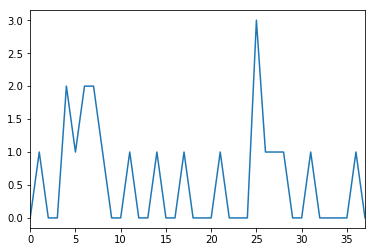

In [319]:
bst_intermittent_items = demand_month[demand_month['demand'] == LUMPY]
item = '00-00000009'
item_sales_temp = sales_month[item].replace(np.nan, 0)
item_sales_temp.plot()
#bst_intermittent_items


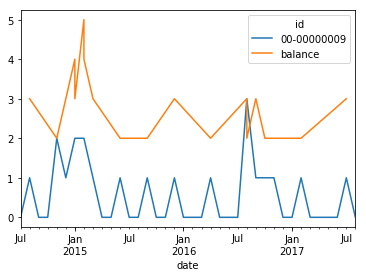

In [320]:
item_balance = balance[balance['id'] == item]
item_balance = item_balance[['date', 'balance']].sort_values('date')
item_balance['date'] = pd.to_datetime(item_balance['date'], format='%Y-%m-%d')
item_balance.set_index('date', inplace=True)

#import matplotlib.dates as dates
item_sales_temp1 = sales_month[['key_date', item]].replace(np.nan, 0)
item_sales_temp1['key_date'] = pd.to_datetime(item_sales_temp1['key_date'], format='%Y-%m-%d')
item_sales_temp1.set_index('key_date', inplace=True)
#item_sales_temp1.head()

ax = item_sales_temp1.plot()
item_balance.plot(ax=ax)

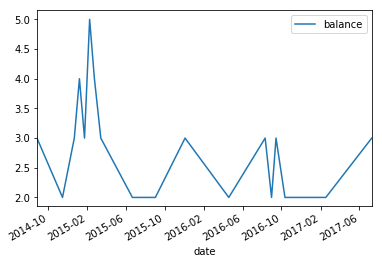

In [321]:
item_balance.head()
item_balance.plot()

####  Frequency

In [322]:
def calc_frequency(data, level):
    value_count = data.value_counts(sort=False)
    pdf = (value_count/len(data)).sort_index()
    cdf = pdf.cumsum()    
    predicted = cdf.where(cdf > level).dropna().index[0]
    return pdf, cdf, predicted

### BRT bootstrapping concept

In [323]:
ldt  = 2 #2 months lead time demand
level = 0.8 # 80% service availability

def brt_bootstrap_item(data, block_size):
    #print(len(data), block_size)
    sum_in_ldt = pd.DataFrame({'sum': np.repeat(np.nan, len(data)-block_size)})
    for i in range(0, len(data) - block_size):
        sum_in_ldt.set_value(index=i, col='sum', value=data.iloc[i-block_size: i].sum())
    return sum_in_ldt
        
bst_item_sales = brt_bootstrap_item(item_sales_temp, ldt)
freq_data, freq_data_cum, predicted = calc_frequency(bst_item_sales.ix[:, 'sum'], level)

#### draw BRT result

Text(0.5,1,'Cumulative')

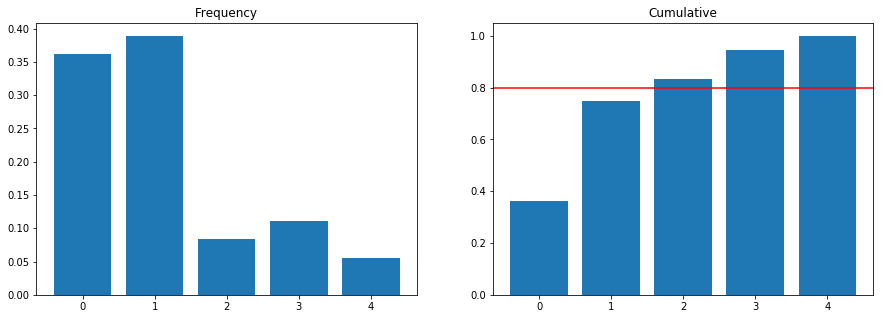

In [325]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(freq_data.index, freq_data)
ax[1].bar(freq_data_cum.index, freq_data_cum)
ax[1].axhline(y=level, xmin=0, xmax=1, color='red')


ax[0].set_title('Frequency')
ax[1].set_title('Cumulative')

 <span style="color:#ff0066; font-size:24px"> можно сказать с вероятностью 80% что за 2 месяца это продукт купят меньше 2 штук в этом магазине</span>

 <span style="color:#ff0066; font-size:24px">закупить = 2 - количество на складе</span>
    

### Test

In [331]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def calc_errors(pred_df):
    return calc_MSE(pred_df), calc_MAPE(pred_df)

def calc_MSE(pred_df):
    pred_df['diff2'] = np.power(pred_df['diff'],2)
    return (pred_df['diff2'].sum())/len(pred_df)    

def calc_MAPE(pred_df):
    pred_df['diff3'] = np.abs(pred_df['diff'])/pred_df['actual']
    return (100/len(pred_df))*(pred_df['diff3'].sum())  

def calc_MAAPE(pred_df):
    pred_df['diff4'] = np.arctan(np.abs(pred_df['diff']/pred_df['actual']))
    return (1/len(pred_df))*(pred_df['diff4'].sum()) 

def divide_to_test_and_validation(series, chunks, ldt, test=0.8):
    len_test = int(chunks*test)
    len_validation = chunks - len_test
    print("    ","chunks_test", len_test, "chunks_val", len_validation)
    len_test_series = ldt*len_test
    data_test = series[0:len_test_series]
    data_val = series[len_test_series:]
    #print(len_test, len_validation)
    return data_test, len_test, data_val, len_validation

def plot_prediction_data(df_validation, sales_test_data_set, ldt):
    predict_plot_data = pd.DataFrame({'y':[]})    
    for i in chunker(sales_test_data_set, ldt):
        predict_plot_data.set_value(index=len(predict_plot_data), col='y', value=i.sum())                    
    predict_plot_data['actual'] = predict_plot_data['y']
    predict_plot_data['predicted'] = predict_plot_data['y']
    #print(len(predict_plot_data), len(df_validation))
    predict_plot_data = predict_plot_data.append(df_validation)[['actual', 'predicted']].reset_index(drop=True)      
    return predict_plot_data    

def plot_result(ax, plotIdx, data, test, len_test_chunks):
    graphx = 0 if plotIdx < 2 else 1
    graphy = int(plotIdx + 1)%2
    plot_cur = ax[graphx][graphy]
    plot_cur.plot(data['actual'])
    plot_cur.plot(data['predicted'])
    plot_cur.set_title("test=" + str(np.round(test, decimals=1)))
    plot_cur.axvline(len_test_chunks - 1, color='red')
       

def run_forecast_test(sales_data, ldt, test=0.6):
    full_validation = pd.DataFrame(columns=['test'])
    full_validation.set_index('test', inplace=True)
    chnks = int(len(sales_data)/ldt)
    print("    ", "ch:", chnks, "len", len(sales_data), "ldt", ldt)
    fig, ax = plt.subplots(2,2,figsize=(20,5))
    fig.tight_layout()
    plot_idx = 0
    while(test < 0.95):
        data_test, len_test_chunks, data_val, len_validation_in_chunks = divide_to_test_and_validation(sales_data, chnks, ldt, test)
        print("    ", "start test on", test*100, "%, data_test:" , len(data_test), ", data_val", len(data_val))
        len_test = len(data_test)
        df = pd.DataFrame({'actual' : np.repeat(np.nan, len_validation_in_chunks), 
                           'predicted': np.repeat(np.nan, len_validation_in_chunks)})
        idx = 0
        for i in chunker(data_val, ldt):        
            bst_item_sales = brt_bootstrap_item(data_test, ldt)
            freq_data, freq_data_cum, predicted = calc_frequency(bst_item_sales.ix[:, 'sum'], level)    
            df.set_value(index=idx, col='actual', value=i.sum())
            df.set_value(index=idx, col='predicted', value=predicted)        
            data_test = data_test.append(i)    
            idx += 1        
        df['diff'] = df['actual'] - df['predicted']   
        full_validation.set_value(index=test, col='length(n)', value=len(df)) 
        full_validation.set_value(index=test, col='MSE', value=calc_MSE(df))    
        full_validation.set_value(index=test, col='MAPE', value=calc_MAPE(df))    
        full_validation.set_value(index=test, col='MAAPE', value=calc_MAAPE(df))  
        plot_result(ax, plot_idx, plot_prediction_data(df, sales_data[0:len_test], ldt), test, len_test_chunks)
        print(df)
        plot_idx += 1
        test += 0.1          
    return full_validation

     ch: 19 len 38 ldt 2
     chunks_test 11 chunks_val 8
     start test on 60.0 %, data_test: 22 , data_val 16
   actual  predicted  diff  diff2     diff3     diff4
0     0.0        3.0  -3.0    9.0       inf  1.570796
1     3.0        2.0   1.0    1.0  0.333333  0.321751
2     2.0        2.0   0.0    0.0  0.000000  0.000000
3     1.0        1.0   0.0    0.0  0.000000  0.000000
4     1.0        3.0  -2.0    4.0  2.000000  1.107149
5     0.0        3.0  -3.0    9.0       inf  1.570796
6     0.0        2.0  -2.0    4.0       inf  1.570796
7     1.0        2.0  -1.0    1.0  1.000000  0.785398
     chunks_test 13 chunks_val 6
     start test on 70.0 %, data_test: 26 , data_val 12
   actual  predicted  diff  diff2     diff3     diff4
0     2.0        2.0   0.0    0.0  0.000000  0.000000
1     1.0        1.0   0.0    0.0  0.000000  0.000000
2     1.0        3.0  -2.0    4.0  2.000000  1.107149
3     0.0        3.0  -3.0    9.0       inf  1.570796
4     0.0        2.0  -2.0    4.0       inf

,length(n),MSE,MAPE,MAAPE
test,,,,
0.6,8.0,3.5,inf,0.865836
0.7,6.0,3.0,inf,0.839023
0.8,4.0,4.5,inf,1.258535
0.9,2.0,2.5,inf,1.178097


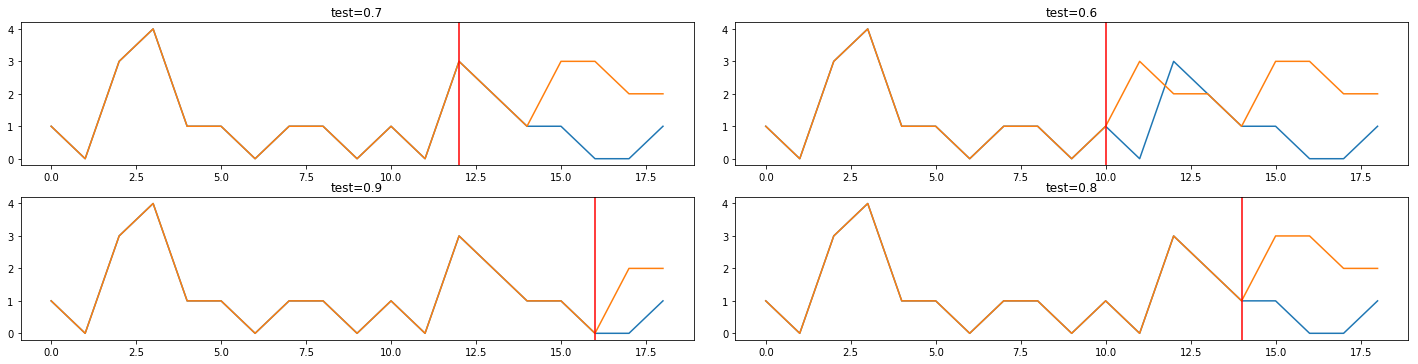

In [332]:
run_forecast_test(sales_month[item].replace(np.nan, 0), 2).head(5)

     ch: 19 len 76 ldt 4
     chunks_test 11 chunks_val 8
     start test on 60.0 %, data_test: 44 , data_val 32
     chunks_test 13 chunks_val 6
     start test on 70.0 %, data_test: 52 , data_val 24
     chunks_test 15 chunks_val 4
     start test on 80.0 %, data_test: 60 , data_val 16
     chunks_test 17 chunks_val 2
     start test on 89.99999999999999 %, data_test: 68 , data_val 8


,length(n),MSE,MAPE,MAAPE
test,,,,
0.6,8.0,1.875000,inf,0.825617
0.7,6.0,1.666667,inf,0.785398
0.8,4.0,2.500000,inf,1.178097
0.9,2.0,2.500000,inf,1.178097


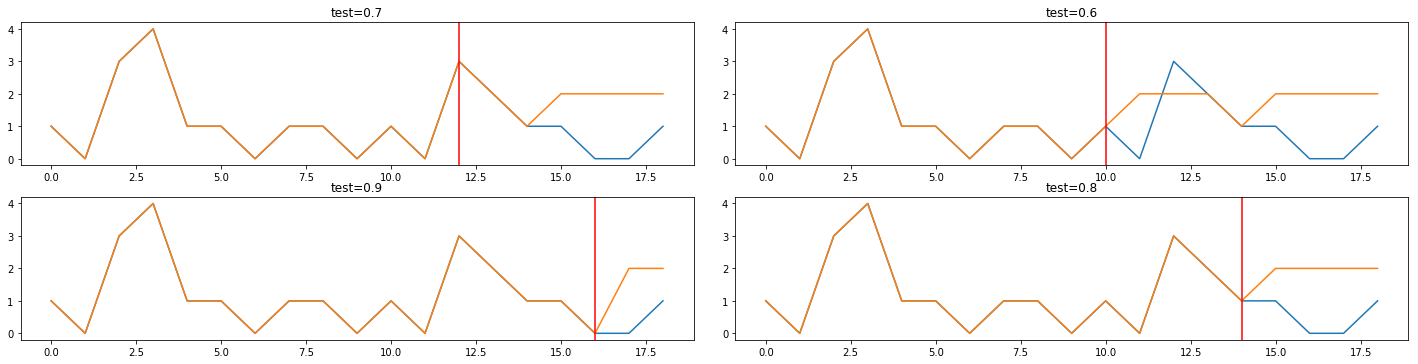

In [328]:
run_forecast_test(sales_2week[item].replace(np.nan, 0), 4).head(5)

     ch: 18 len 150 ldt 8
     chunks_test 10 chunks_val 8
     start test on 60.0 %, data_test: 80 , data_val 70
     chunks_test 12 chunks_val 6
     start test on 70.0 %, data_test: 96 , data_val 54
     chunks_test 14 chunks_val 4
     start test on 80.0 %, data_test: 112 , data_val 38
     chunks_test 16 chunks_val 2
     start test on 89.99999999999999 %, data_test: 128 , data_val 22


,length(n),MSE,MAPE,MAAPE
test,,,,
0.6,9.0,1.888889,inf,0.908415
0.7,7.0,1.714286,inf,0.831363
0.8,5.0,2.200000,inf,1.099557
0.9,3.0,3.000000,inf,1.308997


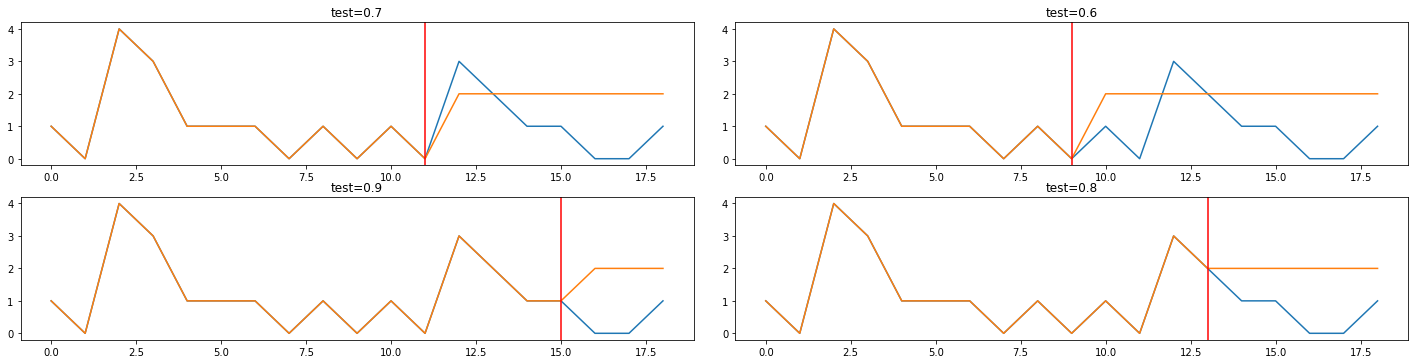

In [329]:
run_forecast_test(sales_week[item].replace(np.nan, 0), 8).head(5)

     ch: 18 len 1137 ldt 60
     chunks_test 10 chunks_val 8
     start test on 60.0 %, data_test: 600 , data_val 537
     chunks_test 12 chunks_val 6
     start test on 70.0 %, data_test: 720 , data_val 417
     chunks_test 14 chunks_val 4
     start test on 80.0 %, data_test: 840 , data_val 297
     chunks_test 16 chunks_val 2
     start test on 89.99999999999999 %, data_test: 960 , data_val 177


,length(n),MSE,MAPE,MAAPE
test,,,,
0.6,9.0,2.333333,inf,1.011447
0.7,7.0,2.285714,inf,0.963833
0.8,5.0,2.200000,inf,1.099557
0.9,3.0,3.000000,inf,1.308997


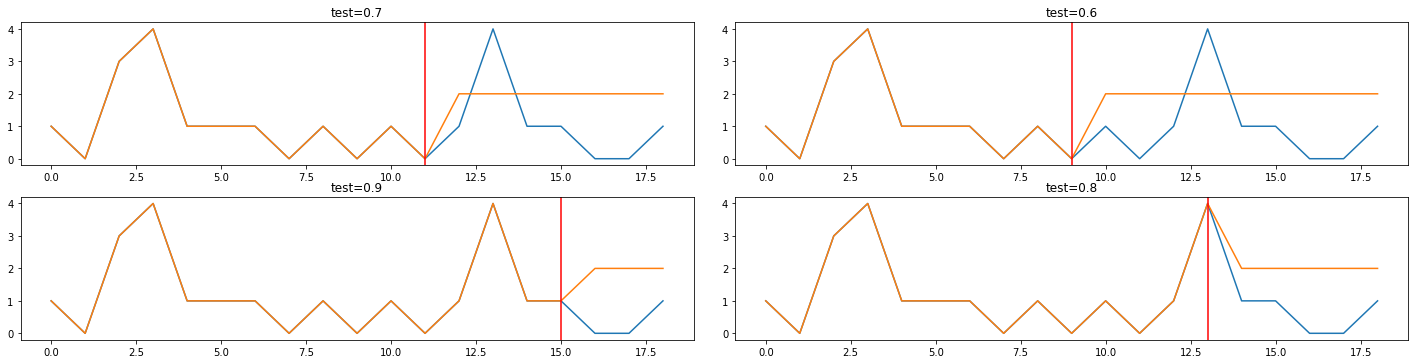

In [330]:
run_forecast_test(sales_day[item].replace(np.nan, 0), 60).head(5)

In [163]:
def brt_bootstrap_wrapper(x, sales_data, ldt, level):
    sales_x = sales_data[x].replace(np.nan, 0)
    brt_sales_x = brt_bootstrap_item(sales_x, ldt)
    freq_data_x, freq_data_cum_x, predicted_x = calc_frequency(brt_sales_x.ix[:, 'sum'], level)    
#     fig, ax = plt.subplots(1,2, figsize=(10,3))
#     ax[0].bar(freq_data_x.index, freq_data_x)
#     ax[1].bar(freq_data_cum_x.index, freq_data_cum_x)
#     ax[1].axhline(y=level, xmin=0, xmax=1, color='red')
#     ax[0].set_title('Frequency')
#     ax[1].set_title('Cumulative')
    return predicted_x

def brt_bootstrap_all(demand, sales, ldt, level, col='predicted'):
    bst_intermittent = demand[demand['demand'].isin(intermittent_demand)]
    unique_intermittent_items = bst_intermittent['item'].unique()
    predicted = pd.DataFrame({'item' : unique_intermittent_items})
    predicted[col] = predicted['item'].map(lambda x: brt_bootstrap_wrapper(x, sales, ldt, level))
    return predicted

In [181]:
level = 0.8
predicted_month = brt_bootstrap_all(demand_month, sales_month, 2, level, one_month)

In [182]:
predicted_2week  = brt_bootstrap_all(demand_2week, sales_2week, 4, level, two_weeks)

In [195]:
predicted_week = brt_bootstrap_all(demand_week, sales_week, 8, level, one_week)

In [196]:
predicted_day = brt_bootstrap_all(demand_day, sales_day, 60, level, one_day)

In [198]:
def mergeResult(df1, df2, df3, df4):
    return df1.merge(df2, how='outer', on=['item']).merge(df3, how='outer', on=['item']).merge(df4, how='outer', on=['item'])

#predicted = predicted_month.merge(predicted_2week,  how='outer', on=['item']).merge(predicted_week, how='outer', on)
predicted = mergeResult(predicted_month, predicted_2week, predicted_week, predicted_day)

In [205]:
predicted.to_csv('brt_predicted', sep='\t', encoding='utf-8')

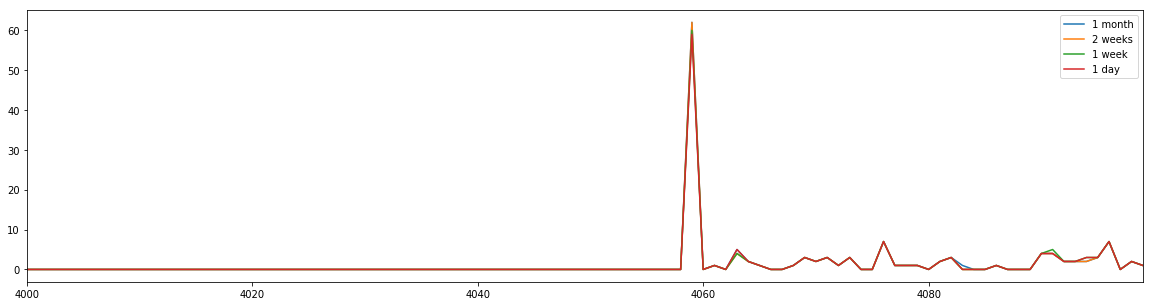

In [206]:
predicted[4000:4100].plot(figsize=(20,5))

In [ ]:
from arch.bootstrap import MovingBlockBootstrap
# bs = MovingBlockBootstrap(lead_time, temp)
# n = 10000
# bst_result = pd.DataFrame({'C': np.repeat(np.nan, n)})
# for data in bs.bootstrap(10000):
# >>> from arch.bootstrap import MovingBlockBootstrap
# >>> from numpy.random import standard_normal
# >>> y = standard_normal((500, 1))
# >>> x = standard_normal((500,2))
# >>> z = standard_normal(500)
# >>> bs = MovingBlockBootstrap(7, x, y=y, z=z)
# >>> for data in bs.bootstrap(100):
# ...     bs_x = data[0][0]
# ...     bs_y = data[1]['y']
# ...     bs_z = bs.z


### MBB bootstrapping concept

- mbb is the same as BRT 
- distribution of ts should be normal? 
- block length

### CROSTON concept

Predicted: 1.17079185755


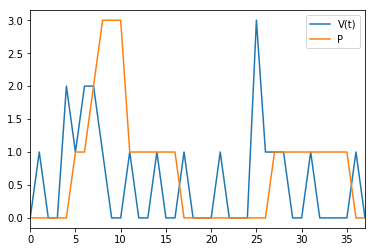

In [277]:
alpha = 0.2
betta = 0.3
#item_sales_temp.plot()
croston_df = item_sales_temp.to_frame()
croston_df.columns = ['V(t)']
croston_df['P(t)'] = np.nan
croston_df['q'] = np.nan
croston_df['X'] = np.nan
croston_df['Z'] = np.nan

if (croston_df.ix[0]['V(t)'] == 0):
    croston_df.ix[0]['Z']  = 1
    croston_df.ix[0]['X']  = 2
else:
    croston_df.ix[0]['Z']  = croston_df.ix[0]['V(t)']
    croston_df.ix[0]['X']  = 1

croston_df.ix[0]['q']  = 0
    
for i in range(1, len(croston_df)):
    if (croston_df.ix[i]['V(t)'] == 0):
        croston_df.ix[i]['q']  = croston_df.ix[i - 1]['q'] + 1   
        croston_df.ix[i]['Z'] = croston_df.ix[i - 1]['Z']
        croston_df.ix[i]['X'] = croston_df.ix[i - 1]['X']
    else:
        croston_df.ix[i]['Z']  = croston_df.ix[i - 1]['Z'] + alpha*(croston_df.ix[i]['V(t)'] - croston_df.ix[i - 1]['Z'])
        croston_df.ix[i]['X']  =  croston_df.ix[i - 1]['X'] + betta*(croston_df.ix[i - 1]['q'] - croston_df.ix[i - 1]['X'])
        croston_df.ix[i]['q'] = 0

croston_df['P(t)'] = croston_df['Z']/ croston_df['X']
croston_df['P'] = croston_df['P(t)'].astype(int)
croston_df

if (round((len(croston_df) - 1)/croston_df.ix[37]['Z']) > 0):
    predicted = croston_df.ix[37]['Z']
else:
    predicted = 0
    
print("Predicted:", predicted)
croston_df

croston_df[['V(t)','P']].plot()



### Poisson concept

## NON-INTERMITTENT DEMAND: Holt-Winters, Neural-Network

### TensorFlow

In [ ]:
#split data to train and validation set
def split_raw_data(data, val_size = 0.2, test_size=0.2):
    ntest = int(round(len(data)*(1-test_size))) #test set starts from ntest
    nval = int(round(len(data.iloc[:ntest])*(1-val_size))) # val set starts from nval
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    return df_train, df_val, df_test

train_set, val_set, test_set = split_raw_data(raw_data); 

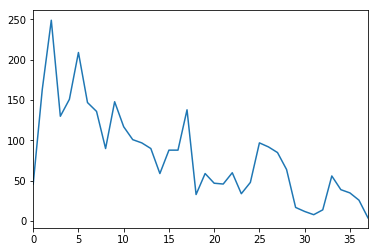

In [52]:
import tensorflow as tf

#smooth
demand_month[demand_month['demand'] == SMOOTH] #РТ-00000009
name_item = "РТ-00000009"
raw_data = sales_month[name_item]
raw_data.plot()

time_steps = 2
batch_size = 1

#### data preparation

In [54]:
# convert timeseries to (x,y)
def rnn_data(data, time_steps, labels=False): #X - false, Y - True
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)


train_x = rnn_data(train_set, time_steps)
train_y = rnn_data(train_set, time_steps, True)

In [55]:
# prepare timeseries
def prepare_data(data, time_steps, labels=False, val_size=0.05, test_size=0.05):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))

In [61]:
#rnn
num_units = 1
depth = 3
rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
stacked_ltsm = tf.nn.rnn_cell.MultiRNNCell([rnn_cell]  * depth)
x_split = tf.split(train_x, time_steps, 1)

initial_state = state = stacked_ltsm.zero_state(batch_size, tf.float32)

for i in range(time_steps):
    output, state = stacked_ltsm(x_split[:, i], state)

    
final_state = state


TypeError: list indices must be integers or slices, not tuple

In [ ]:
def LTSM_Regressor(features, labels, mode, params):
   # Logic to do the following:
   # 1. Configure the model via TensorFlow operations
   # 2. Define the loss function for training/evaluation
   # 3. Define the training operation/optimizer
   # 4. Generate predictions
   # 5. Return predictions/loss/train_op/eval_metric_ops in EstimatorSpec object
   return EstimatorSpec(mode, predictions, loss, train_op, eval_metric_ops)

# Set model params
model_params = {"learning_rate": LEARNING_RATE}

# Instantiate Estimator
nn = tf.estimator.Estimator(model_fn=LTSM_Regressor, params=model_params)

### Forecasting: Intermitent demand [lumpy, slow]

In [386]:
lumpy_demand = demand_month[demand_month['demand'] == LUMPY]
#bins
n_rounded = round(1+ 3.322 * math.log(lumpy_demand['periods_with_demand'].unique()[0]))
lumpy_demand['bin'] = round((lumpy_demand['max'] - lumpy_demand['min'])/n_rounded).astype(int)


item = '00-00000058'
item_df = pd.DataFrame(index=sales_month.index,columns=['item', 'pdf'])
item_df['item'] = sales_month[item].replace(np.nan, 0)
# item_df['pdf'] = item_df['item'].value_counts(normalize=True,dropna=False)
item_data = lumpy_demand[lumpy_demand['item'] == item]
min = item_data['min'].values[0].astype(int)
max = item_data['max'].values[0].astype(int)
bin = item_data['bin'].values[0]

bin

1

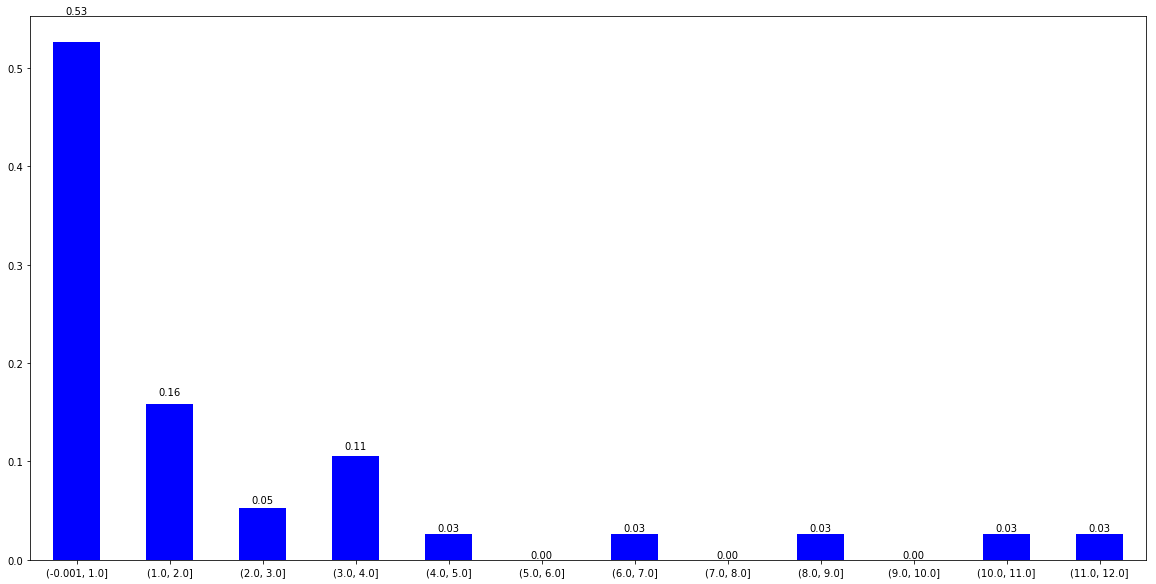

In [364]:
def autolabel(rects, labels):
    # attach some text labels
    i = 1
    for rect in rects:
        text = "{0:.2f}".format(labels[i])
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        i+=1

def showHist(data):
    ax = data.plot.bar(rot=0, color="b", figsize=(20,10))
    return ax;
    
            

bins = list(range(0, max, bin))
item_df['binned'] = pd.cut(item_df['item'], bins,include_lowest=True)
item_value_hist = item_df['binned'].value_counts(sort=False)
item_pdf_hist = item_value_hist/38
ax = showHist(item_pdf_hist)
autolabel(ax.patches, item_pdf_hist)


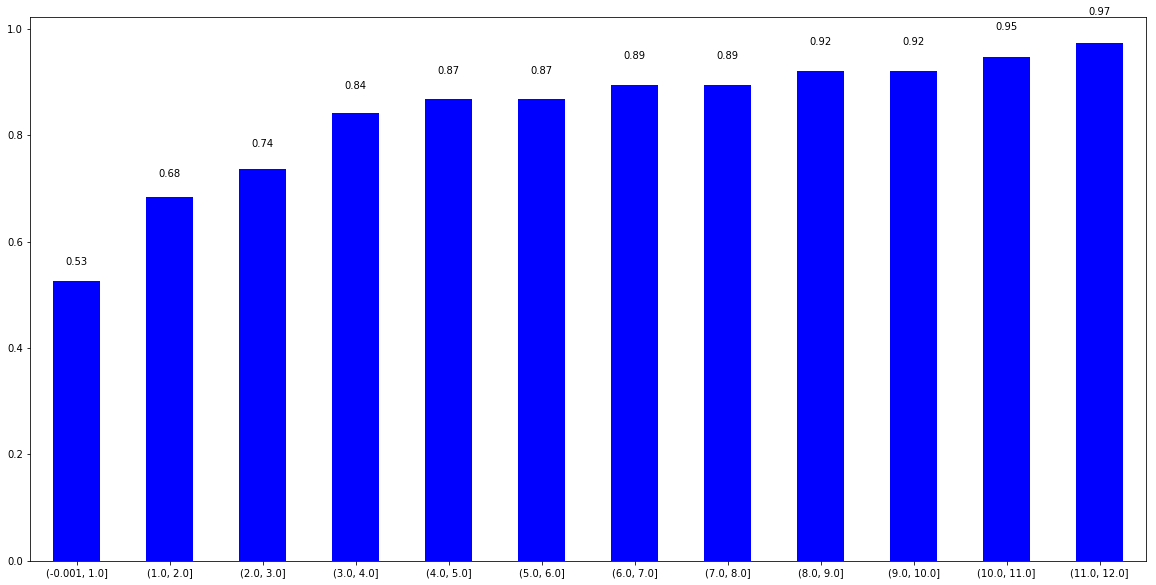

In [358]:
item_cdf_hist = item_pdf_hist.cumsum()
ax = showHist(item_cdf_hist)
autolabel(ax.patches, item_cdf_hist)



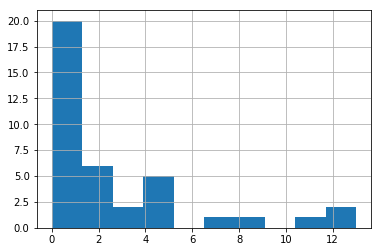

In [359]:
#pdf_df[item]
sales_month[item].replace(np.nan, 0)
sales_month[item].hist()
#sales_month[item].hist(cumulative='True')

Text(0.5,1,'hist = hist / hist.sum()')

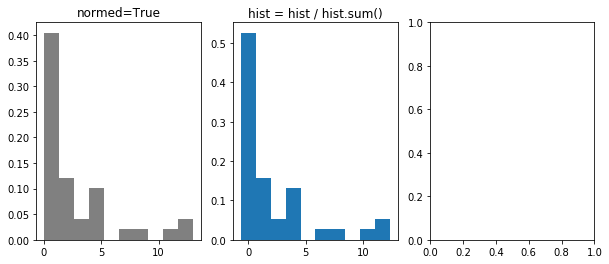

In [360]:
x = sales_month[item]
fig, ax = plt.subplots(1,3, figsize=(10,4))

ax[0].hist(x, normed=True, color='grey')

hist, bins = np.histogram(x)
ax[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))


ax[0].set_title('normed=True')
ax[1].set_title('hist = hist / hist.sum()')

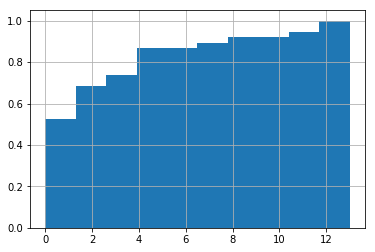

In [294]:
item_pdf = sales_month[item].hist(normed=True, cumulative='True' )

In [77]:
item_pdf

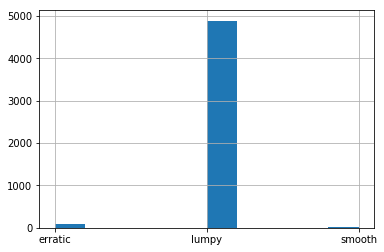

In [87]:
demand_month['demand'].sort_values().hist()

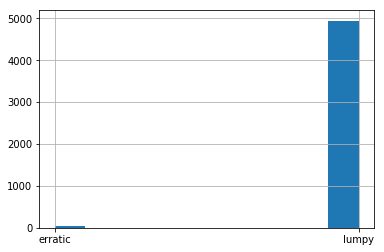

In [89]:
demand_2week['demand'].sort_values().hist()

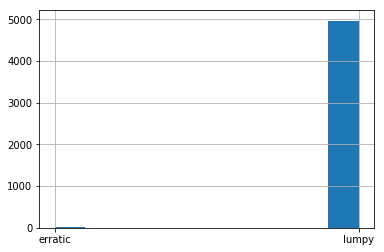

In [90]:
demand_week['demand'].sort_values().hist()

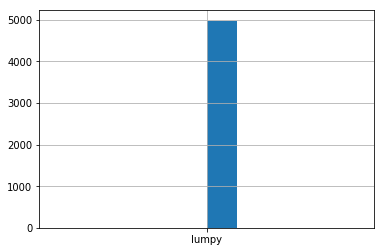

In [91]:
demand_day['demand'].sort_values().hist()

In [17]:
test = sales_month['00-00000003'].copy(deep=True).to_frame()
test['point'] = test.index + 1
test['00-00000003'] = test['00-00000003'].replace(np.nan, 0)
# test['00-00000003'] = test['00-00000003'].replace(0, np.nan)
# test = test.dropna()
# test['point_prev'] = test['point'].shift(1)
# test['diff'] = test['point']-test['point_prev']
test['demand'] = test['00-00000003'] > 0
test['demand'] = test['demand'].astype(int)
test

In [18]:
# not rare - items where sales series doesn't contain zero/NaN values
# missing values are in [0, NaN], threashold = 30%

threashnold_of_missing_data = 0.3 # 30%

def setZeroesInsteadOfNan(data):
    return data.replace(np.nan, 0)

def reduce_items_with_not_stable_sales(data): #sales of items have > 30% missing values
    total_row_count = data['key_date'].count()
    missingValues = data.replace(0, np.nan).isnull().sum().sort_values(ascending=False).to_frame().reset_index()
    missingValues.columns = ['id', 'missed']
    missingValues['percentage'] = missingValues['missed']/total_row_count # % of missing values
    threshold = 1 - threashnold_of_missing_data
    to_remove = missingValues[missingValues['percentage'] > threshold]
    reduced = data.copy(deep=True).drop(to_remove['id'], axis=1)
    print("total row count:", total_row_count, ", before:", missingValues['id'].count(), 
           ", removed:", to_remove['id'].count(), ", after: ~", len(reduced.columns))
    return reduced


In [19]:
#sales_month.isnull().sum().sort_values(ascending=False).hist()
reduced_sales_m = reduce_items_with_not_stable_sales(sales_month)
reduced_sales_m.head()


total row count: 38 , before: 4977 , removed: 3803 , after: ~ 1174


id,key_date,00-00000003,00-00000004,00-00000005,00-00000009,00-00000010,00-00000011,00-00000027,00-00000031,00-00000033,...,УТ000000975,УТ000000977,УТ000000978,УТ000000982,УТ000000983,УТ000000984,УТ000001012,УТ000001013,УТ000001140,УТ000001301
0,2014-07-01,4.0,4.0,6.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,1.0,19.0,53.0,NaN,NaN
1,2014-08-01,1.0,3.0,8.0,1.0,2.0,NaN,1.0,6.0,NaN,...,3.0,8.0,NaN,3.0,NaN,6.0,107.0,104.0,3.0,3.0
2,2014-09-01,7.0,10.0,9.0,NaN,NaN,1.0,NaN,2.0,NaN,...,NaN,3.0,NaN,NaN,NaN,5.0,129.0,80.0,6.0,3.0
3,2014-10-01,2.0,5.0,9.0,NaN,NaN,1.0,3.0,6.0,NaN,...,1.0,2.0,6.0,NaN,NaN,6.0,126.0,127.0,4.0,4.0
4,2014-11-01,2.0,8.0,8.0,2.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,7.0,2.0,NaN,2.0,81.0,98.0,1.0,2.0


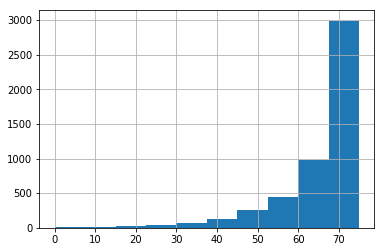

In [20]:
sales_2week.isnull().sum().sort_values(ascending=False).hist()

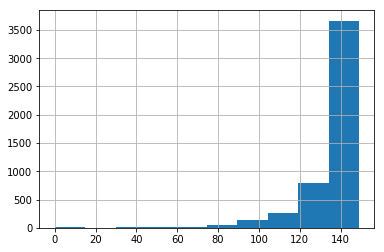

In [21]:
sales_week.isnull().sum().sort_values(ascending=False).hist()

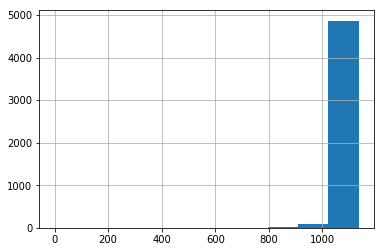

In [22]:
sales_day.isnull().sum().sort_values(ascending=False).hist()